# WMT Budget 
## (using ERA5 | GLORYS | MATT's model)

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm

In [2]:
sst_ds = xr.open_dataset('/work5/stb/ERA5/sst.nc', chunks={})
mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc', chunks={})
glorys = xr.open_dataset('glorys_vars.nc', chunks={})
heat_fluxes = xr.open_dataset('/work/Shanice.Bailey/ERA5/era-heat-fluxes.nc', chunks={})
#heat_fluxes = xr.open_dataset('/work/Shanice.Bailey/ERA5/heat-fluxes_1959-2021.nc', chunks={})

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [3]:
sst_ds

<xarray.Dataset> Size: 8GB
Dimensions:                  (latitude: 55, longitude: 69, time: 552264)
Coordinates:
  * latitude                 (latitude) float32 220B 31.0 30.75 ... 17.75 17.5
  * longitude                (longitude) float32 276B 262.0 262.2 ... 279.0
  * time                     (time) datetime64[ns] 4MB 1959-01-01 ... 2021-12...
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 8GB dask.array<chunksize=(552264, 55, 69), meta=np.ndarray>

# 1) Process budget variables 
(to desired spatial/grid and temporal configuration)

In [4]:
time_slice = dict(time=slice('1993', '2021'))
gom = dict(longitude=slice(-98, -81), latitude=slice(17.5, 31))

sst_g = glorys.thetao.sel(**gom).isel(depth=0).drop_vars('depth')
sst = sst_ds.sea_surface_temperature.sel(**time_slice)
mask = mask_ds.land_sea_mask

sw = heat_fluxes.ssr.sel(**time_slice) / (60*60) #W/m2
lw = heat_fluxes.str.sel(**time_slice) / (60*60) #W/m2
sh = heat_fluxes.sshf.sel(**time_slice) / (60*60) #W/m2
lh = heat_fluxes.slhf.sel(**time_slice) / (60*60) #W/m2

In [5]:
sst

<xarray.DataArray 'sea_surface_temperature' (time: 254208, latitude: 55,
                                             longitude: 69)> Size: 4GB
dask.array<getitem, shape=(254208, 55, 69), dtype=float32, chunksize=(254208, 55, 69), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * time       (time) datetime64[ns] 2MB 1993-01-01 ... 2021-12-31T23:00:00

In [ ]:
#resample to daily
sst_resampled = sst.resample(time='D').mean()

#daily clim
clim = sst_resampled.groupby('time.dayofyear').mean('time')
#clim_std = sst_resampled.groupby('time.dayofyear').std('time')
anom = sst_resampled.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst_resampled.groupby('time.month').mean('time')
#mo_clim_std = sst_resampled.groupby('time.month').std('time')
mo_anom = sst_resampled.groupby('time.month') - mo_clim

In [ ]:
# Find 90th, 95th, 99th percentile temperatures
q99 = sst.quantile(0.99, dim='time')
q95 = sst.quantile(0.95, dim='time')
q90 = sst.quantile(0.90, dim='time')

/vftmp/Shanice.Bailey/pid2365002/ipykernel_3296260/3042954675.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Greys")


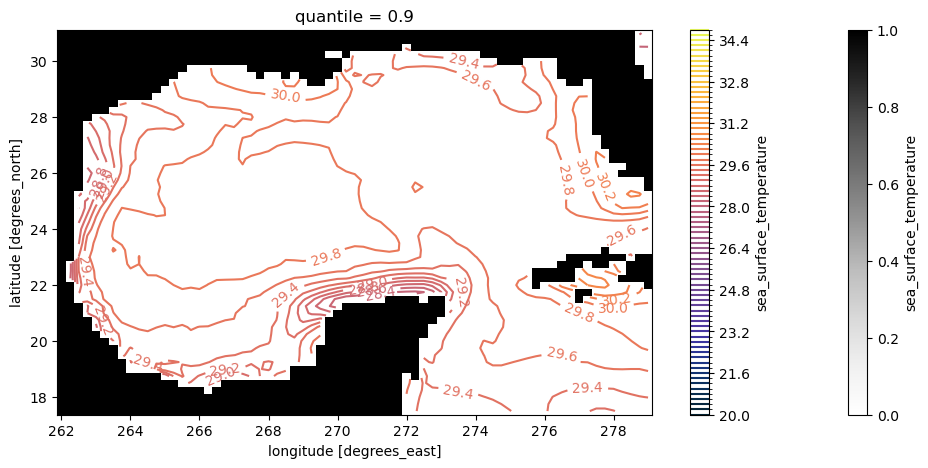

In [14]:
theta_levs = np.arange(20,35,0.2)

fig, ax = plt.subplots(figsize=(12,5))
cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap)
C = q90.plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

In [ ]:
# Define isotherm values to represent the MHW

# 2) Compute LHS ($\frac{\partial V}{\partial t}$)
(but not really dVdt)

## Create grid and area objects

In [ ]:
ds_pt_full = generate_grid_ds(glorys, {'X':'longitude', 'Y':'latitude'})
grid_pt_full = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'])#, boundary="fill", fill_value=0.)

In [ ]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [ ]:
cell_elements_glorys = deg_2_m(grid_pt_full, ds_pt_full, 'latitude', 'longitude')

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_glorys.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_glorys.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_glorys.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_glorys.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

### `dVdt` using `.where(thetao>=31.8)`

In [ ]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

dz = glorys.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz
masked_vol = vol.where(glorys.thetao[:, 1:, :, :-1]>=31.8) #m^3
vol_tot = masked_vol.sum(['latitude', 'longitude', 'depth']) #m^3
M = vol_tot * 1034 #kg
V = M / 1034 #m^3

dt_values = (np.diff(V.time)/1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], coords={'time':(['time'], V.time.values[1:])})

dVdt = V.diff('time', label='upper') / dt #m^3/s

### `dVdt` using `histogram(thetao, weights=vol)`

In [ ]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

dz = glorys.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz
#masked_vol = vol.where(gopaf_pottemp.thetao[:, 1:, :, :-1]>=31.8) #m^3
#vol_tot = masked_vol.sum(['latitude', 'longitude', 'depth']) #m^3
#M = vol_tot * 1034 #kg
#V = M / 1034 #m^3

#expanded tbin range to include colder temps because cumsum method wasn't matching with other dvdt definitions
delta_theta = 0.1
theta_bins = np.arange(0,34,delta_theta)

tdist = histogram(glorys.thetao[:,1:,:,:-1].rename('theta'), bins=[theta_bins],
                  weights=vol, dim=['latitude', 'longitude', 'depth']) #˚C m^3

In [ ]:
V = tdist.isel(theta_bin=slice(None, None, -1)).cumsum(dim='theta_bin')
V.transpose().plot(yincrease=False, robust=True, cmap=cmocean.cm.thermal, vmax=2e14)
plt.grid();

In [ ]:
plt.figure(figsize=(8,3))
(V[-1] - V[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
V[0].plot(label='first timestep', color='b')
V[-1].plot(label='last timestep', color='r')
V.sel(time='2023-08-15', method='nearest').plot(label='max area', color='green')
plt.legend()
#plt.xlim(1037, 1037.3)
plt.grid();

In [ ]:
(V[-1] - V[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
plt.grid();

In [ ]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.grid();

In [ ]:
V.sel(theta_bin=slice(None, 31.8)).T.plot(yincrease=False)

In [ ]:
delta_V = V.diff(dim='time')
dVdt = delta_V / 86400

In [ ]:
(dVdt/1e6).sel(theta_bin=31.8, method='nearest').plot(label='=31.8')
(dVdt/1e6).sel(theta_bin=slice(None, 31.8)).sum('theta_bin').plot(label='>31.8', linestyle='dashed')
plt.legend();

In [ ]:
#Just checking (5_... nb)
V32 = tdist.sel(theta_bin=slice(31.8, None)).sum('theta_bin')

delta_V32 = V32.diff(dim='time')
dVdt32 = delta_V32 / 86400

In [ ]:
(dVdt/1e6).sel(theta_bin=31.8, method='nearest').plot(label='cumsum dvdt')
(dVdt32/1e6).plot(label='slice,sum,tdist', linestyle='dashed')
plt.legend()
plt.grid()

# 3) Compute RHS ($G_\Omega(\theta)$)
- where $\Omega$ is the surface boundary of the WWM of the MHW event in $\theta$ space
- where $G$ is the temperature tendencies due to surface heat fluxes
- surface terms come from ERA5

## Create grid and area objects

In [ ]:
ds_full_e = generate_grid_ds(era, {'X':'longitude', 'Y':'latitude'})
#ds_full_m = generate_grid_ds(merra, {'X':'lon', 'Y':'lat'})

grid_e = xgcm.Grid(ds_full_e, periodic='X')
#grid_m = xgcm.Grid(ds_full_m, periodic='X')

In [ ]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [ ]:
cell_elements_e = deg_2_m(grid_e, ds_full_e, 'latitude', 'longitude')
#cell_elements_m = deg_2_m(grid_m, ds_full_m, 'lat', 'lon')

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_e.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_e.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_e.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_e.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

#### Create mask

In [ ]:
mask_e = era.sst[0].isnull()
#mask_m = merra.TSKINWTR[0].isnull()

In [ ]:
dx_interp_e = grid_e.interp(cell_elements_e.dx_l, 'Y')
area_e = dx_interp_e * cell_elements_e.dy_l

#dx_interp_m = grid_m.interp(cell_elements_m.dx_l, 'Y')
#area_m = dx_interp_m * cell_elements_m.dy_l

In [ ]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1027 #kg/m^3 #according to Harte Research Institute(https://www.harteresearch.org/sites/default/files/inline-files/3.pdf)

#(W/m^2) x 1/Cp x 1/rho x area
era_weighted = (era.isel(longitude=slice(None, -1), latitude=slice(None, -1)) * 
                area_e.isel(longitude=slice(None, -1), latitude=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s
#merra_weighted = (merra.isel(lon=slice(None, -1), lat=slice(None, -1)) * 
                 # area_m.isel(lon=slice(None, -1), lat=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s

$$F_{PS77} = Re^{- \frac{z}{h_1}} + (1-R)e^{- \frac{z}{h_2}}$$
where $R = 0.58$, $h_1 = 0.35$ m, $h_2 = 0.23$ m (eq from Groeskamp and Iudicone 2018 GRL)

In [ ]:
glorys.depth.values

In [ ]:
#Create decay function for SSR penetration
#Jerlov Type 1 (upper 50m)
R = 0.68
h1 = 1.2 #m
h2 = 28 #m
z_values = np.array([0, 5.0576001e-01, 1.5558553e+00, 2.6676817e+00, 3.8562799e+00,
       5.1403613e+00, 6.5430336e+00, 8.0925188e+00, 9.8227501e+00,
       1.1773680e+01, 1.3991038e+01, 1.6525322e+01, 1.9429802e+01,
       2.2757616e+01, 2.6558300e+01, 3.0874561e+01, 3.5740204e+01,
       4.1180023e+01, 4.7211895e+01, 5.3850636e+01, 6.1112839e+01,
       6.9021683e+01, 7.7611160e+01, 8.6929428e+01, 9.7041313e+01,
       1.0803028e+02, 1.2000000e+02, 1.3307582e+02, 1.4740625e+02,
       1.6316446e+02, 1.8054993e+02, 1.9978996e+02, 2.2114117e+02,
       2.4489062e+02, 2.7135638e+02, 3.0088751e+02, 3.3386282e+02,
       3.7068848e+02, 4.1179385e+02, 4.5762561e+02, 5.0863989e+02,
       5.6529230e+02, 6.2802600e+02, 6.9725867e+02, 7.7336829e+02,
       8.5667896e+02, 9.4744788e+02, 1.0458542e+03, 1.1519912e+03,
       1.2658615e+03, 1.3873770e+03, 1.5163636e+03, 1.6525685e+03,
       1.7956708e+03, 1.9452955e+03, 2.1010266e+03, 2.2624216e+03,
       2.4290251e+03, 2.6003804e+03, 2.7760393e+03, 2.9555703e+03,
       3.1385649e+03, 3.3246409e+03, 3.5134456e+03, 3.7046567e+03,
       3.8979819e+03, 4.0931587e+03, 4.2899526e+03, 4.4881548e+03,
       4.6875811e+03, 4.8880698e+03, 5.0894785e+03, 5.2916831e+03,
       5.4945752e+03, 5.6980605e+03, 5.9020576e+03])
z = xr.DataArray(data=z_values, dims={'depth'}, coords={'depth':z_values})
F_ps77 = R * np.exp(-z/h1) + (1-R) * np.exp(-z/h2)

#expand ssr da in z dimension then apply decay function 
ssr_Zexpanded = era_weighted.ssr.expand_dims({'depth':z}) 
ssr_z = ssr_Zexpanded * (F_ps77)

In [ ]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(F_ps77, z)
ax0.set_ylim(100, 0)
ax0.grid()

ax1.plot(z.diff(dim='depth'), z.diff(dim='depth').depth)
ax1.set_ylim(5000,0)
#ax1.set_xlim(0, None)
ax1.grid()

plt.tight_layout();

In [ ]:
era_weighted.ssr.sum(['latitude', 'longitude']).plot(color='k')
ssr_z.sum(['latitude', 'longitude']).isel(depth=0).plot(color='blue', linestyle='--')

In [ ]:
dFlx = ssr_z.diff(dim='depth')
dz = z.diff(dim='depth')
dFlxdz = - dFlx / dz

In [ ]:
sst_g = glorys.thetao_glor.sel(longitude=slice(None, -80.25), latitude=slice(None, 30.75))
#sst_ig = sst_g.interp()

In [ ]:
sst_g.shape

In [ ]:
dFlxdz.transpose('time', 'depth', 'latitude', 'longitude').shape

In [ ]:
delta_theta = 0.1
theta_bins = np.arange(20, 38, delta_theta)

def hist_func(sst, ds, lat, lon, variable):
    hist = histogram(sst.rename('theta'), bins=[theta_bins],
                    weights=ds[variable].fillna(0.),
                    dim=[lon, lat]) / delta_theta
    return hist #m^3/s (Sv)

def hist_func_ssrz(sst, da, lat, lon, depth):
    hist_srp = histogram(sst.rename('theta'), bins=[theta_bins],
                    weights=da.fillna(0.),
                    dim=[lon, lat, depth]) / delta_theta
    return hist_srp #m^3/s (Sv)


In [ ]:
sst_e = era.sst.isel(longitude=slice(None, -1), latitude=slice(None, -1)).where(~mask_e)
era_hist = xr.merge([hist_func(sst_e, 
                               era_weighted.where(~mask_e),
                               'latitude', 'longitude', var).rename('omega_'+var) 
                     for var in list(era_weighted)[:-1]])
#sst_m = merra.TSKINWTR.isel(lon=slice(None, -1), lat=slice(None, -1)).where(~mask_m)
#merra_hist = xr.merge([hist_func(sst_m, 
#                                 merra_weighted.where(~mask_m),
#                                 'lat', 'lon', var).rename('omega_'+var)
#                      for var in list(merra_weighted)[:-1]])

In [ ]:
ssrz_hist = hist_func_ssrz(sst_g.assign_coords({'depth':dFlxdz.depth}),
                     dFlxdz.transpose('time', 'depth', 'latitude', 'longitude').where(~mask_e),
                     'latitude', 'longitude', 'depth').rename('omega_ssrz')

In [ ]:
#merge new ssr da into era_hist and run clim calculations for uploading new clim datasets for fig 3 in manuscript
era_hist['omega_ssrz'] = ssrz_hist

In [ ]:
plt.figure(figsize=(25,5))
(era_hist/1e6).to_array().plot(col='variable', col_wrap=2, x='time', 
                               yincrease=False, robust=True, 
                               cbar_kwargs={'shrink': 0.8, 'label':'Sv'})
plt.suptitle('ERA Transformation', y=1.05);

### Save histogram ds

In [ ]:
#upload new ssr da
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/era_hist.zarr')
era_hist.to_zarr(gcsmap_ds, mode='w')